<div class="alert alert-warning">
<h1>Advanced Statistical Inference - Assessed Exercise</h1>
<h2>Daniele Reda</h2>
</div>

<h3>Note on color codings</h3>
<div class="label label-warning">Yellow</div> is used for titles and subtitles
<div class="label label-default">Transparent</div> is used for formulas, explanations and informations
<div class="label label-info">Blue</div> is used to write the questions asked by the assessed exercise
<div class="label label-success">Green</div> is used for the answers to the questions
<div class="label label-danger">Red</div> is for to-dos (hopefully you shouldn't see any of these)

<h3>Introduction and Instruction</h3>
<br>
In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
<br>
<ul>
<li>http://yann.lecun.com/exdb/mnist/
<li>https://www.cs.toronto.edu/~kriz/cifar.html
</ul>
<br>
Listed below are various exercises to undertake.

<div class="alert alert-info">
Download the MNIST and CIFAR10 datasets and import them.
</div>

In [37]:
from keras.datasets import mnist, cifar10

(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar10_train_data, cifar10_train_label), (cifar10_test_data, cifar10_test_label) = cifar10.load_data()

Keras has been used for easier and faster loading of the data.

<div class="alert alert-info">
Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.
</div>

In [38]:
import os
import sys
import re
import random
import functools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix, log_loss
import itertools

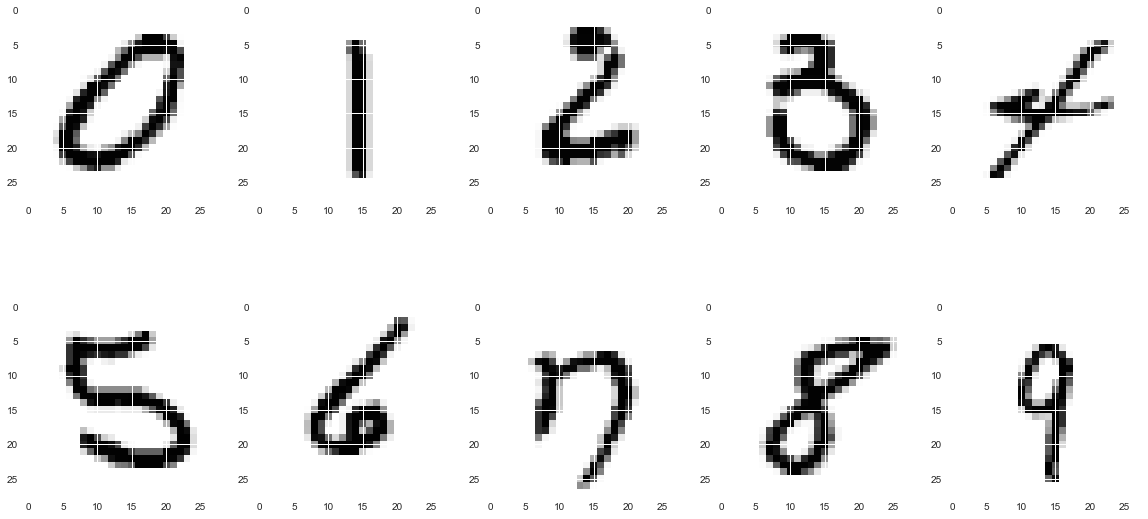

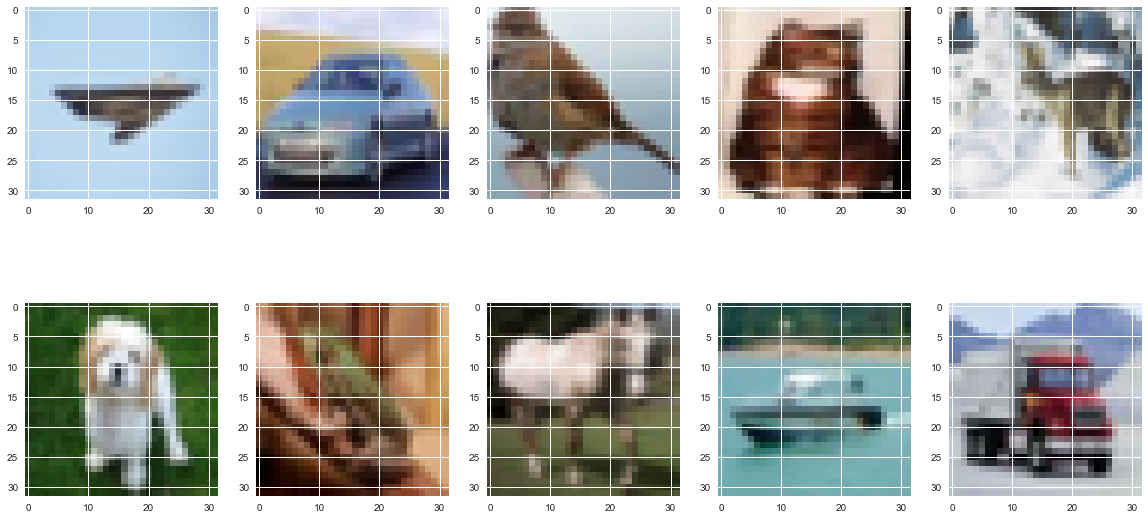

In [39]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
fig, axes = plt.subplots(2,5)
dist_mnist = []
for k, ax in enumerate(axes.flatten()):
    x = [mnist_train_data[_] for _ in np.arange(len(mnist_train_data)) if mnist_train_label[_]==k]
    dist_mnist.append(x)
    ax.imshow(x[np.random.randint(0, len(x))])
plt.show()

fig, axes = plt.subplots(2,5)
dist_cifar = []
for k, ax in enumerate(axes.flatten()):
    x = [cifar10_train_data[_] for _ in np.arange(len(cifar10_train_data)) if cifar10_train_label[_]==k]
    dist_cifar.append(x)
    ax.imshow(x[np.random.randint(0, len(x))])
plt.show()

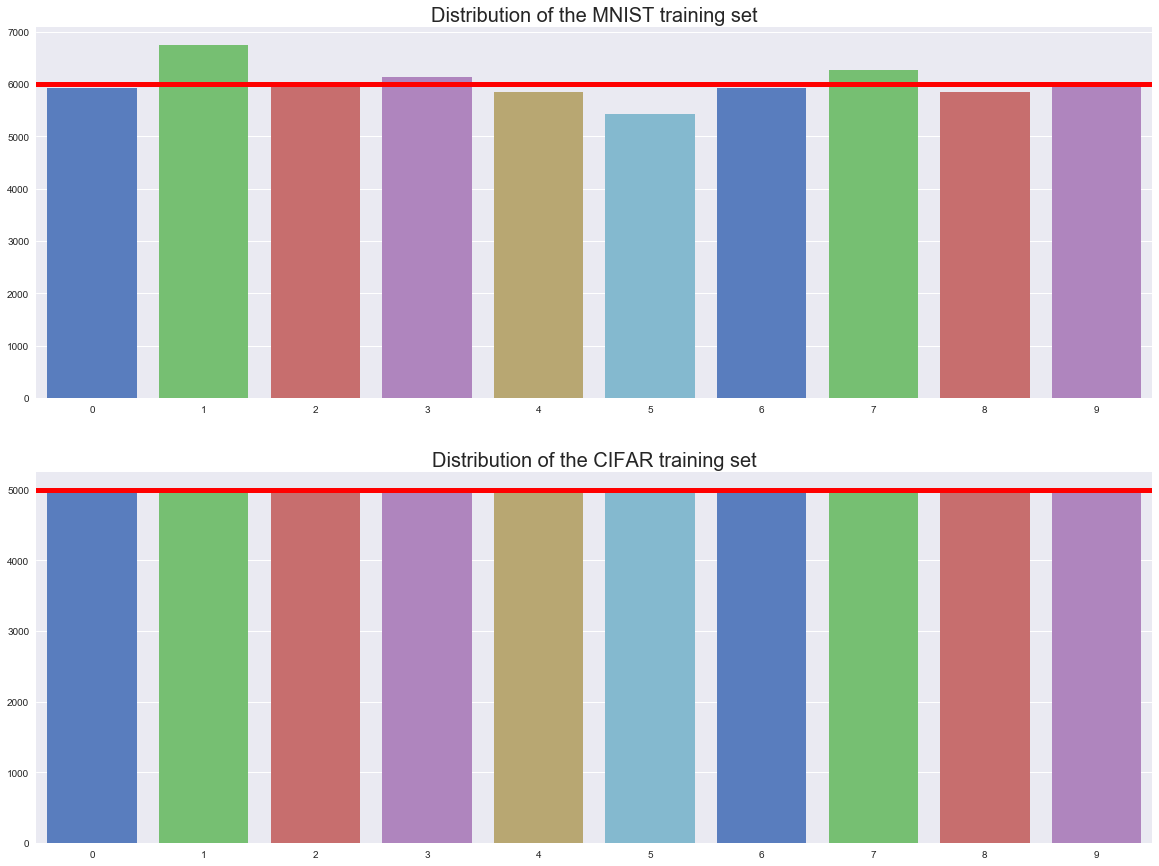

In [40]:
plt.figure(figsize=(20,15))
plt.subplot(211)
sns.barplot(x=np.arange(len(dist_mnist)), y=[len(_) for _ in dist_mnist], \
            palette=sns.color_palette("muted"))
plt.plot([-5, 10], [6000, 6000], linewidth=5, c="r")
plt.title("Distribution of the MNIST training set", fontsize=20)

plt.subplot(212)
sns.barplot(x=np.arange(len(dist_cifar)), y=[len(_) for _ in dist_cifar], \
            palette=sns.color_palette("muted"))
plt.plot([-5, 10], [5000, 5000], linewidth=5, c="r")
plt.title("Distribution of the CIFAR training set", fontsize=20)
plt.show()

<div class="alert alert-success">
Regarding the distribution of the dataset, we can see that MNIST has 60000 training images but the classes are not divided equally (ie. there are not 6000 images for each class). Although the discrepancies are not really high, this may cause problems since priors are not the same.
<br><br>
CIFAR instead, as we can see from the second plot above, has exactly 5000 images for each label, out of the 50000 images of the training set.
</div>

In [41]:
print("MNIST dataset")
print("\tTraining set:", len(mnist_train_data))
print("\tTest set:", len(mnist_test_data))
print("\tDimensionality of data:", mnist_train_data[0].shape)

print("\nCIFAR dataset")
print("\tTraining set:", len(cifar10_train_data))
print("\tTest set:", len(cifar10_test_data))
print("\tDimensionality of data:", cifar10_train_data[0].shape)

MNIST dataset
	Training set: 60000
	Test set: 10000
	Dimensionality of data: (28, 28)

CIFAR dataset
	Training set: 50000
	Test set: 10000
	Dimensionality of data: (32, 32, 3)


<div class="alert alert-success">
Regarding the dimensions instead, MNIST dataset is composed by 60000 training images and 10000 test images. Each image is a (28,28) numpy array where each cell is a number from 0 to 255 that represents the black and white color.
<br><br>
CIFAR instead has 50000 images in the training set and the same 10000 images in the test set. Each image is a 3-dimensional array of (32,32,3) that is: 3 layers (RGB) of (32,32) each.
<br><br>
We have to pay attention when flattening the sets especially with CIFAR since a (32,32,3) image becomes a (3072,1) and if we don't normalize the data, the computation reaches overflow.
</div>

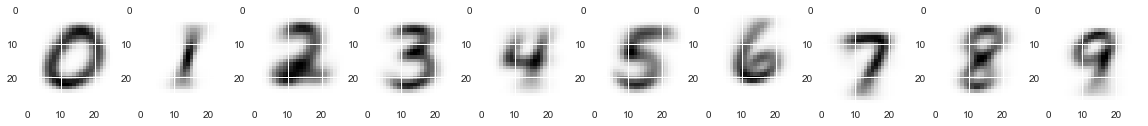

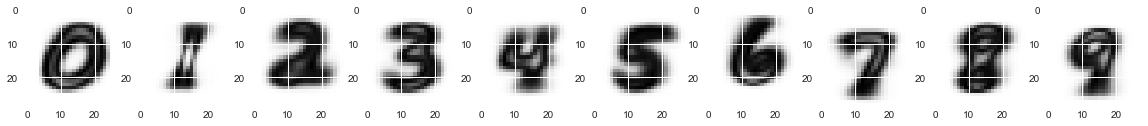

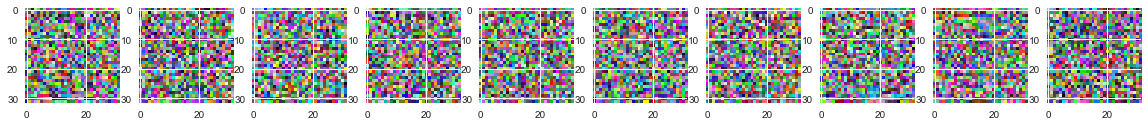

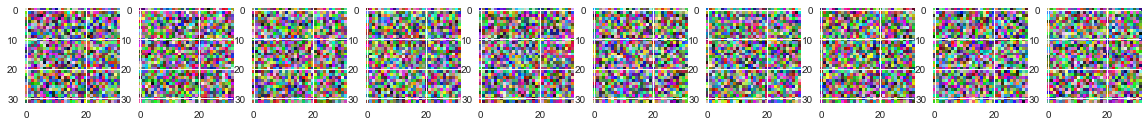

In [42]:
dic = {k:[] for k in range(10)}
for _ in range(len(mnist_train_data)):
    dic[mnist_train_label[_]].append(mnist_train_data[_])

mnist_means = np.array([np.array(dic[k]).mean(axis=0) for k in range(10)])
mnist_vars = np.array([np.array(dic[k]).var(axis=0) for k in range(10)])

fig, axes = plt.subplots(1,10)
for k, ax in enumerate(axes.flatten()):
    ax.imshow(mnist_means[k])
plt.show()

fig, axes = plt.subplots(1,10)
for k, ax in enumerate(axes.flatten()):
    ax.imshow(mnist_vars[k])
plt.show()

dic = {k:[] for k in range(10)}
for _ in range(len(cifar10_train_data)):
    dic[cifar10_train_label[_][0]].append(cifar10_train_data[_])

cifar_means = np.array([np.array(dic[k]).mean(axis=0) for k in range(10)])
cifar_vars = np.array([np.array(dic[k]).var(axis=0) for k in range(10)])

fig, axes = plt.subplots(1,10)
for k, ax in enumerate(axes.flatten()):
    ax.imshow(cifar_means[k])
plt.show()

fig, axes = plt.subplots(1,10)
for k, ax in enumerate(axes.flatten()):
    ax.imshow(cifar_vars[k])
plt.show()

<div class="alert alert-success">
Plotted above are the images with the mean and the variance of every pixel for the two datasets.
<br><br>
As we can see, MNIST is quite recognizable instead CIFAR becomes super messy. With these images, we can hypothise that CIFAR will perform badly with naïve Bayes since it's difficult to find recurrent colors in pixels.
</div>

<div class="alert alert-warning">
<h2>Classification</h2>
</div>

<div class="alert alert-info">
Implement the Naïve Bayes classifier.
</div>

The naïve Bayes classifier is a very simple probabilistic classifier based on Bayes rule:
<br><br>
\begin{equation}
P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )
= \frac {P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
        {\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
\end{equation}
<br><br>
given that:
<ul>
<li>$\mathbf{X}$ is the data of our training set
<li>$\mathbf{t}$ are the labels of our training set
<li>$\mathbf{x}_{new}$ is the sample we want to classify
<li>$t_{new}$ is the class of our sample we want to evaluate
</ul>
<br>
We define the elements of the Bayes rule as:
<ul>
<li><b>Posterior</b>: $P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )$
<ul><li>It's the probability of $\mathbf{x}_{new}$ belonging to class $k$ given the training set $\mathbf{X}$ and its labels $\mathbf{t}$</ul>
<li><b>Likelihood</b>: $P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ )$
<ul><li>It is a density (<b>not</b> a probability) telling how likely it is that, given that the label of the element is $k$, we are able to see an element like $\mathbf{x}_{new}$</ul>
<li><b>Prior</b>: $P( \ t_{new}=k \ )$
<ul><li>It is the probability of finding the label $k$ without any observations on the data.</ul>
<li><b>Marginal likelihood</b>: $\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )$
<ul><li>Normalisation constant.</ul>
</ul>
<br>
The <i>likelihood</i> for a label $k$ is defined as:
\begin{equation}
\prod\limits_{d=1}^{K}\mathcal{N}(\mu_{kd}, \ \sigma^2_{kd})
\end{equation}
where $\mu_{kd}$ and $\sigma^2_{kd}$ are:
\begin{align*}
\mu_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} x_{nd} \\
\sigma^2_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} (x_{nd} - \mu_{kd})^2
\end{align*}
<br>
and so it becomes, for mnist, a product of 784 gaussians. <i>Why 784?</i> Because mnist images are 28x28 and when we flat the matrix we get a vector of 784 elements and we have to build a gaussian for each pixel that represents the distribution of the color of that pixel for that label. The same happens for cifar where each image is a 32x32 matrix with 3 channels and so it gets fatten into a 32x32x3=3072 numpy array.
<br><br>
The <i>prior</i> for a label $k$ is defined as:
\begin{equation}
\frac{nr. \ of \ elements \ of \ label \ k}{total \ nr. \ of \ elements}
\end{equation}
<br><br>
Below is the code for computing naïve Bayes.

In [43]:
def get_prior(data, size):
    return len(data)/size
    
def get_means_and_variances(data):
    means = np.array(data).mean(axis=0)
    var = np.array(data).var(axis=0) + 1e-3
    #var_corrected = np.array([x if x>0 else 1e-3 for x in var])
    return (means, var)

def get_likelihood(means, variances, sample):
    #return np.sum(norm(means, variances).logpdf(sample))
    #return np.prod(np.float128(np.exp(-(sample-means)**2/(2*variances)) / np.sqrt(2*np.pi*variances)))
    return np.sum(np.float128((-0.5 * np.log(2 * np.pi * variances)) -(sample - means)**2 / (2 * variances)))
    
def get_marginal_likelihood(likelihoods, priors):
    return np.sum(np.multiply(likelihoods, priors))

def get_posterior(likelihoods, priors, marginal_likelihood):
    #return np.multiply(likelihoods, priors)/marginal_likelihood
    return likelihoods + priors - marginal_likelihood
    
def predict(data, labels, samples, norm=None, mnist=True, log_likelihood=False):
    train_size = len(data)
    test_size = len(samples)
    
    data = data.reshape(train_size, -1)
    samples = samples.reshape(test_size, -1)
    
    if type(norm) is int:
        data = data/norm
        samples = samples/norm
        
    dict_per_label = {k:[] for k in np.unique(labels)}
    for _ in np.arange(train_size):
        if mnist is True:
            dict_per_label[labels[_]].append(data[_])
        else:
            dict_per_label[labels[_][0]].append(data[_])
                
    priors = np.array([get_prior(dict_per_label[k], train_size) for k in np.unique(labels)])
    
    means_and_variances = [get_means_and_variances(dict_per_label[k]) for k in np.unique(labels)]
    predictions = []
    probabilities = []
    for sample in samples:
        likelihoods = np.array([get_likelihood(_[0], _[1], sample) for _ in means_and_variances])
        marginal_likelihood = get_marginal_likelihood(likelihoods, priors)
        probabilities_k = get_posterior(likelihoods, priors, marginal_likelihood)
        predictions.append(np.argmax(probabilities_k))
        probabilities.append(probabilities_k)
    if log_likelihood is True:
        return predictions, np.array(probabilities)
    return predictions

<div class="alert alert-info">
Describe a positive and a negative feature of the classifier for these tasks.
</div>

<div class="alert alert-success">
Naïve Bayes is a very simple classifier. Because of this, it works well only under certain conditions.
<br><br>First of all, it's highly biased by the different labels in the training set. If the classifier <i>sees</i> during the training only a certain number of labels, it will never be able to predict a completely new label.
<br><br>Also, if the distribution of labels in the training set is highly unbalanced, the predictions would be biased.
</div>

<div class="alert alert-info">
Describe any data pre-processing that you suggest for this data and your classifier.
</div>

<div class="alert alert-success">
Some pre-processing has been done to the dataset before being able to use the classifier.
<br><br>First of all, each pixel is a number between 0 and 255 and it has been normalized from 0 to 1 in order to not make numbers increase very fast.
<br><br>Second, many pixels, especially in the corners, are useless and for all images keep the same background color without seeing any variation. When evaluating means and variances, these pixels will have a variance of 0 that when evaluated in the Gaussian and multiplied to get the likelihood, will zero out the full computation.
<br>In order to bypass this problem, a small value ($10^{-3}$) has been summed to all variances.
<br><br>This problem is known as <a href="https://discuss.analyticsvidhya.com/t/zero-frequency-problem/2521/2"><b>zero-frequency problem</b></a>.
<br><br>In order to work easily with vectors, we also had to flatten the dataset obtaining for MNIST a 784-long vector for each image instead for CIFAR a 3072-long vector.
</div>

<div class="alert alert-info">
Apply your classifier to the two given datasets.
<br>
Make sure your optimization is clearly commented.
<br>
Use classification accuracy and test log-likelihood as your figures of merit.
</div>

In [44]:
def get_accuracy(predicted, real):
    return np.sum([predicted[k] == real[k] for k in np.arange(len(predicted))])

In [45]:
t1 = time.time()
predictions_mnist_bayes, probabilities_mnist_bayes = predict(mnist_train_data, mnist_train_label, mnist_test_data, \
                                                 norm=255, log_likelihood=True)
print("Time for Mnist: %.3f seconds" %(time.time()-t1))
correct = get_accuracy(predictions_mnist_bayes, mnist_test_label)
print("Accuracy: " + str(correct/100) + "%")
print("Log-likelihood:", log_loss(mnist_test_label, probabilities_mnist_bayes))

Time for Mnist: 7.625 seconds
Accuracy: 77.46%
Log-likelihood: 2.09177821715


In [46]:
t1 = time.time()
predictions_cifar_bayes, probabilities_cifar_bayes = predict(cifar10_train_data, cifar10_train_label, cifar10_test_data, \
                                                 mnist=False, norm=255, log_likelihood=True)
print("Time for Cifar: %.3f seconds" %(time.time()-t1))
correct = get_accuracy(predictions_cifar_bayes, cifar10_test_label)
print("Accuracy: " + str(correct/100) + "%")
print("Log-likelihood:", log_loss(cifar10_test_label, probabilities_cifar_bayes))

Time for Cifar: 19.411 seconds
Accuracy: 29.6%
Log-likelihood: 7.39267276988


<div class="alert alert-info">
Display the confusion matrix on the test data.
</div>

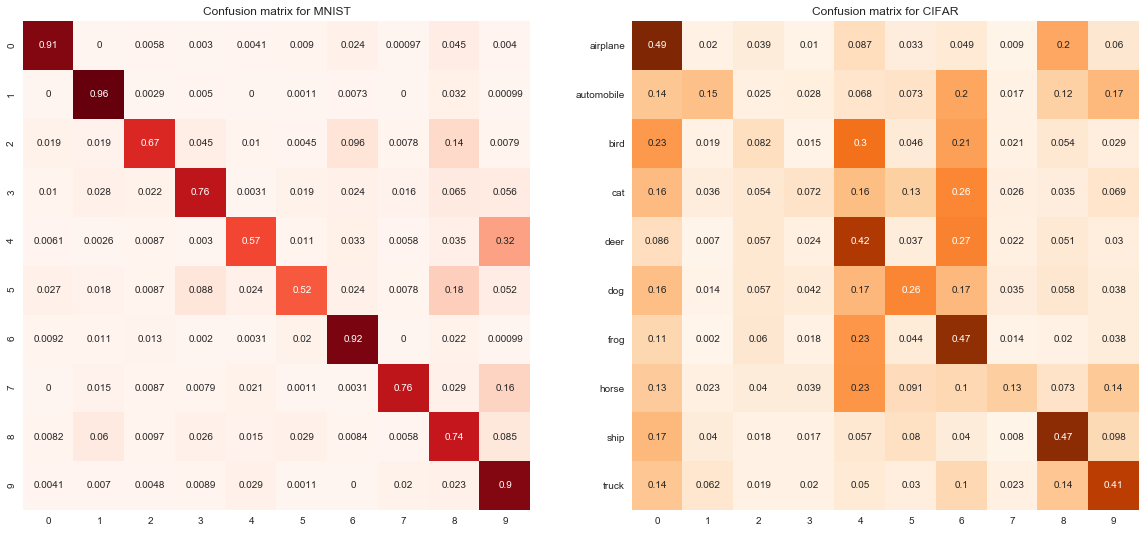

In [47]:
cm_mnist = confusion_matrix(mnist_test_label, predictions_mnist_bayes)
cm_mnist_norm = cm_mnist / cm_mnist.sum(axis = 1)
cm_cifar = confusion_matrix(cifar10_test_label, predictions_cifar_bayes)
cm_cifar_norm = cm_cifar / cm_cifar.sum(axis = 1)
fig, axes = plt.subplots(1,2, figsize=(20,9))
axes = axes.flatten()
axes[0].set_title("Confusion matrix for MNIST")
sns.heatmap(cm_mnist_norm, cbar=False, cmap='Reds', annot=True, \
            yticklabels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], \
            ax=axes[0])

axes[1].set_title("Confusion matrix for CIFAR")
sns.heatmap(cm_cifar_norm, cbar=False, cmap='Oranges', annot=True, \
            yticklabels=["airplane", "automobile", "bird", "cat", "deer", \
                         "dog", "frog", "horse", "ship", "truck"], \
            ax=axes[1])
plt.show()

<div class="alert alert-info">
Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved.
</div>

In [48]:
random_mnist = np.random.randint(low=0, high=10, size=len(mnist_test_label))
random_cifar = np.random.randint(low=0, high=10, size=len(cifar10_test_label))
correct_mnist = get_accuracy(random_mnist, mnist_test_label)
correct_cifar = get_accuracy(random_cifar, cifar10_test_label)
print("Random classifier for MNIST:\tAccuracy: " + str(correct_mnist/100) + "%")
print("Random classifier for CIFAR:\tAccuracy: " + str(correct_cifar/100) + "%")

Random classifier for MNIST:	Accuracy: 10.34%
Random classifier for CIFAR:	Accuracy: 9.98%


<div class="alert alert-success">
A random classifier has an accuracy of approx. 10%. It's the same result that a classifier would have if it predics always the same value.
<br><br>
Our results for MNIST, with naïve Bayes, are pretty good, topping at approx. 80%. We can see from the confusion matrix that the greatest error happens with data from class 4 that is predicted nearly half of the times as class 9 (instead the opposite doesn't happen a lot).
<br><br>
Regarding CIFAR, the accuracy is much lower, around 30%, and as we can see from the confusion matrix, the <i>bird</i> and the <i>cat</i> images are almost predicted randomly being that images of all classes get predicted as those classes.
<br>
<h3>Performance improvement suggestions</h3>
<br>
Many ways came into my mind to improve performances:
<br>
<ul>
<li>As suggested from <a href="http://www-inst.eecs.berkeley.edu/~cs70/sp15/notes/n21_slides.pdf">this set of slides from the CS70 course of Berkeley</a>, a way to improve predictions could be to convert the image to black and white instead to grayscale so that pixels would have value or 0 or 1 and not a real number in between those two. Results online for this implementation vary up to 85%.
<br><br>
<li>Another way, would be to remove the hypothesis that every pixel is independent and take into account correlation between pixel values.
<br>I tried to implement <b>multivariate gaussian naïve Bayes</b> below but had too many problems with the covariance matrix and zero determinants that I will try it again later.
<br><br>
<li>To improve speed, <code>lognormal</code> instead of <code>normal</code> distribution has been used. A further speed bump would occur if we don't evaluate the prior and the marginal_likelihood. But for this, we have to assume that all class labels in the training set are distributed equally (which, as seen above, is not true for MNIST).
</ul>
</div>

<div class="alert alert-warning">
<h2>Linear Regression</h2>
</div>

<div class="alert alert-info">
Implement Bayesian linear regression.
</div>

In [49]:
def get_design_matrix(x, order):
    return np.array([np.array([x_i**n for n in range(order + 1)]).flatten() for x_i in np.array(x)])

def get_w_hat(X, t):
    return np.dot(np.linalg.inv(X.T.dot(X) + np.diag(np.random.uniform(0, 1, X.T.shape[0]))), X.T.dot(t))

def get_predictions(x, t, x_test, order = 0, var=False):
    X = get_design_matrix(x, order)
    X_test = get_design_matrix(x_test, order)
    w_hat = get_w_hat(X, t)
    if var is True:
        return X_test.dot(w_hat), get_variance(X, t, w_hat)
    return X_test.dot(w_hat)

def get_variance(X, t, w_hat):
    A = t - X.dot(w_hat)
    return A.T.dot(A) / t.size

<div class="alert alert-info">
Treat class labels as continuous and apply regression to the training data.
</div>

In [14]:
x = mnist_train_data.reshape(len(mnist_train_data), -1) / 255
t = mnist_train_label
x_test = mnist_test_data.reshape(len(mnist_test_data), -1) / 255

In [15]:
orders = [1, 2, 3, 4]
predictions_mnist_regression = []
for order in orders:
    t1 = time.time()
    predictions_mnist_regression.append(get_predictions(x, t, x_test, order))
    t2 = time.time() - t1
    print("Time for order %d: %.2f seconds" %(order, t2))

Time for order 1: 11.20 seconds
Time for order 2: 18.91 seconds
Time for order 3: 32.83 seconds
Time for order 4: 51.44 seconds


In [16]:
x = cifar10_train_data.reshape(len(cifar10_train_data), -1) / 255
t = cifar10_train_label
x_test = cifar10_test_data.reshape(len(cifar10_test_data), -1) / 255

In [17]:
t1 = time.time()
predictions_cifar_regression = get_predictions(x, t, x_test, 1)
t2 = time.time() - t1
print("Time for order 1: %.2f seconds" %(t2))

Time for order 1: 119.17 seconds


For cifar, only order 1 has been produced because, during test, I saw that the time to compute increasing orders was too much and the accuracy wasn't increasing a lot.

<div class="alert alert-info">
Produce a scatter plot showing the predictions versus the true targets for the test set and compute the mean squared error on the test set.
</div>

In [50]:
#mean square error
def mse(pred, true):
    return np.sum(np.array([(pred[x]-true[x])**2 for x in range(len(pred))])) / len(pred)

In [32]:
for k in range(len(orders)):
    print("MSE for MNIST, order %d: %f" %(orders[k], mse(predictions_mnist_regression[k], mnist_test_label)))

print("\nMSE for CIFAR, order 1: %f" %(mse(predictions_cifar_regression, cifar10_test_label)))

MSE for MNIST, order 1: 3.149619
MSE for MNIST, order 2: 2.469025
MSE for MNIST, order 3: 2.466935
MSE for MNIST, order 4: 2.465138

MSE for CIFAR, order 1: 7.900678


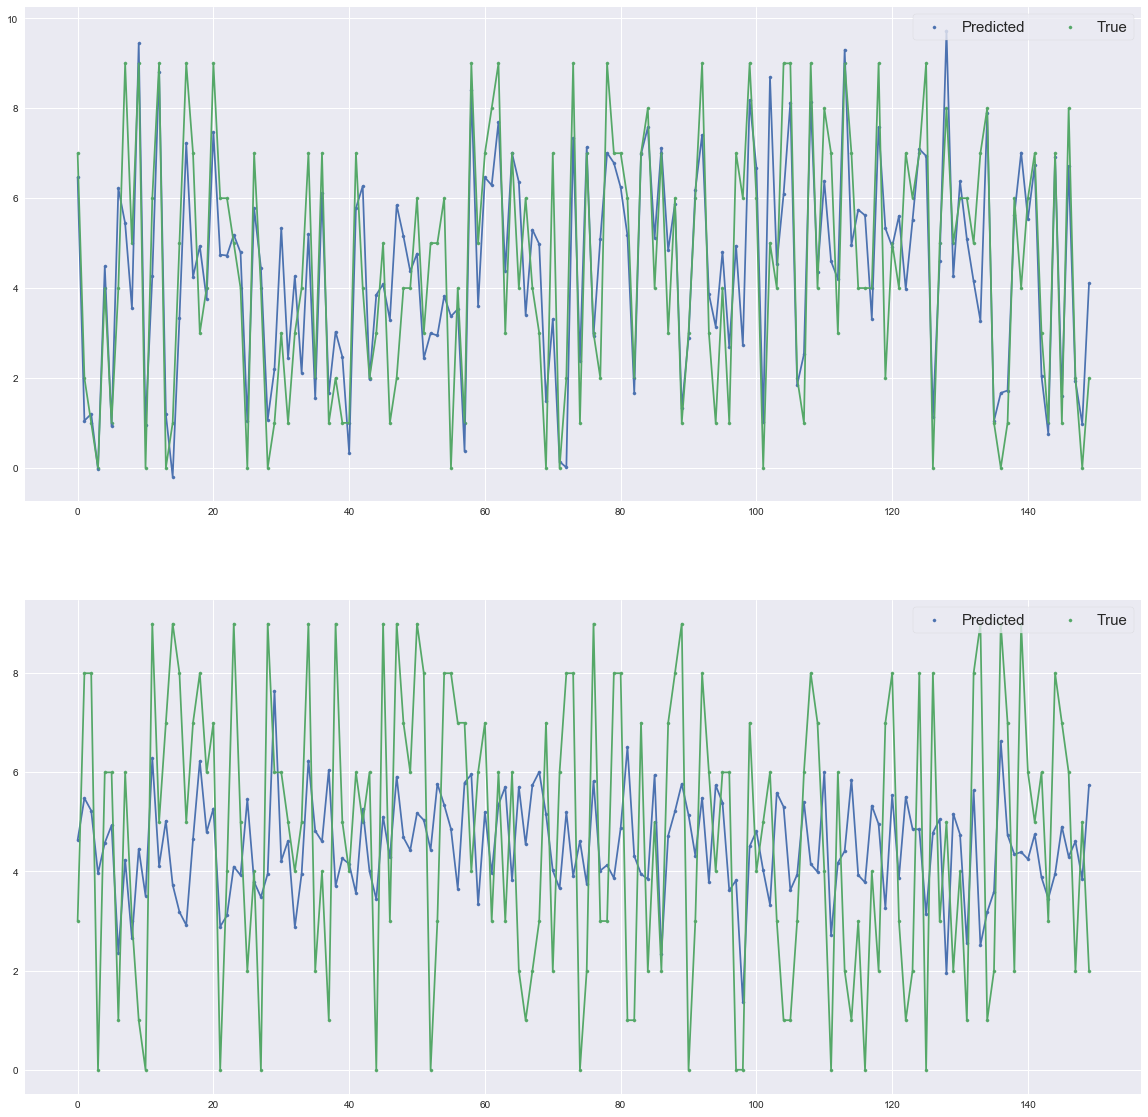

In [19]:
num = 150

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(range(num), predictions_mnist_regression[3][0:num])
plt.plot(range(num), mnist_test_label[0:num])
plt.scatter(range(num), predictions_mnist_regression[3][0:num], s=10, label="Predicted")
plt.scatter(range(num), mnist_test_label[0:num], s=10, label="True")
plt.legend(ncol=2, loc='upper right', frameon=True, fontsize=15)

plt.subplot(212)
plt.plot(range(num), predictions_cifar_regression[0:num])
plt.plot(range(num), cifar10_test_label[0:num])
plt.scatter(range(num), predictions_cifar_regression[0:num], s=10, label="Predicted")
plt.scatter(range(num), cifar10_test_label[0:num], s=10, label="True")
plt.legend(ncol=2, loc='upper right', frameon=True, fontsize=15)
plt.show()

<div class="alert alert-info">
Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy.
</div>

<div class="alert alert-success">
To discretize the continuous predictions from the linear regression, many ways, after looking at the data, came to the mind.
<br>
<ul>
<li>
First of all, taking the <code>int</code> part of the continuous real number is the "easiest" discretization.
<br>It actually gives good results, reaching almost 30% with MNIST and a 4th order approximation.
<br><br>
<li>
A more accurate way to discretize would be to <code>np.round</code> in order that it reaches the nearest integer instead of the lowest one.
<br>Strangely, it gives worse results than the approximation with integer.
<br><br>
<li>Looking at the data, we see that some values are negative and some predicted values are over 10. A "trick" that could be performed to improve the approximation could be to shift all negative values to 0 and all values over 10. 
</ul>
</div>

In [20]:
def my_disc(x):
    d = int(x)
    if d<0:
        d = 0
    if d>9:
        d = 9
    return d

In [21]:
print("Discretization with int() on MNIST")
for k in range(len(orders)):
    prediction_mnist_disc = np.array([int(pred) for pred in predictions_mnist_regression[k]]) 
    print('\tAccuracy Bayesian Linear Regression (order %d): %.2f%%' \
                      % (orders[k], get_accuracy(prediction_mnist_disc, mnist_test_label)/100))
    
print("\nDiscretization with np.round() on MNIST")
for k in range(len(orders)):    
    prediction_mnist_disc = np.array([np.round(pred) for pred in predictions_mnist_regression[k]]) 
    print('\tAccuracy Bayesian Linear Regression (order %d): %.2f%%' \
                      % (orders[k], get_accuracy(prediction_mnist_disc, mnist_test_label)/100))
    
print("\nDiscretization with my_disc() on MNIST")
for k in range(len(orders)):    
    prediction_mnist_disc = np.array([my_disc(pred) for pred in predictions_mnist_regression[k]]) 
    print('\tAccuracy Bayesian Linear Regression (order %d): %.2f%%' \
                      % (orders[k], get_accuracy(prediction_mnist_disc, mnist_test_label)/100))

Discretization with int() on MNIST
	Accuracy Bayesian Linear Regression (order 1): 26.05%
	Accuracy Bayesian Linear Regression (order 2): 29.25%
	Accuracy Bayesian Linear Regression (order 3): 29.37%
	Accuracy Bayesian Linear Regression (order 4): 29.73%

Discretization with np.round() on MNIST
	Accuracy Bayesian Linear Regression (order 1): 22.13%
	Accuracy Bayesian Linear Regression (order 2): 27.04%
	Accuracy Bayesian Linear Regression (order 3): 27.46%
	Accuracy Bayesian Linear Regression (order 4): 27.55%

Discretization with my_disc() on MNIST
	Accuracy Bayesian Linear Regression (order 1): 26.35%
	Accuracy Bayesian Linear Regression (order 2): 29.69%
	Accuracy Bayesian Linear Regression (order 3): 29.82%
	Accuracy Bayesian Linear Regression (order 4): 30.11%


In [31]:
print("Discretization with int() on CIFAR")
prediction_cifar_disc = np.array([int(pred) for pred in predictions_cifar_regression]) 
print('\tAccuracy Bayesian Linear Regression (order 1): %.2f%%' \
                  % (get_accuracy(prediction_cifar_disc, cifar10_test_label)/100))

print("\nDiscretization with np.round() on CIFAR")
prediction_cifar_disc = np.array([np.round(pred) for pred in predictions_cifar_regression]) 
print('\tAccuracy Bayesian Linear Regression (order 1): %.2f%%' \
                  % (get_accuracy(prediction_cifar_disc, cifar10_test_label)/100))

print("\nDiscretization with my_disc() on CIFAR")
prediction_cifar_disc = np.array([np.round(pred) for pred in predictions_cifar_regression]) 
print('\tAccuracy Bayesian Linear Regression (order 1): %.2f%%' \
                  % (get_accuracy(prediction_cifar_disc, cifar10_test_label)/100))

Discretization with int() on CIFAR
	Accuracy Bayesian Linear Regression (order 1): 10.75%

Discretization with np.round() on CIFAR
	Accuracy Bayesian Linear Regression (order 1): 11.32%

Discretization with my_disc() on CIFAR
	Accuracy Bayesian Linear Regression (order 1): 11.32%


<div class="alert alert-info">
Discuss regression performance with respect to classification performance.
</div>

<div class="alert alert-success">
For being a simple linear regression, MNIST results of approx. 30% are good enough and higher than expected.
<br><br>
Given that the regression has been performed on multiple labels, we didn't expect a high result and obviously naïve Bayes got better results.
<br><br>
The bad results of CIFAR of approx. 10%, as much as a random classifier, show us that regression is not a good method to classify images.
</div>

<div class="alert alert-info">
Describe one limitation of using regression for this particular task.
</div>

<div class="alert alert-success">
Regression is particularly useful when the problem is linear (the variables have a linear relationship).
<br><br>
Also, linear regression is very sensitive to outliers. If a lot of data is in one part of the space and some outliers are very far, the whole regression gets shifted.
</div>

<div class="alert alert-warning">
<h3>Bonus: A second approach to regression</h3>
</div>

Discussing with other friends, we believed that there was a better approach for linear regression.

Instead of applying linear regression to the full dataset without any pre processing, we decided to convert the $t$ vector of labels into a matrix such that for every dataset there is a 10-cell long row all set to 0 except the one with the index corresponding to the label of that data like in the following.

\begin{bmatrix}
    1 \\ 5 \\ 8 \\ \vdots \\ 4
\end{bmatrix}

gets transformed into


\begin{bmatrix}
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
    \dots & \dots & \dots & \dots & \dots & \dots & \dots & \dots & \dots & \dots \\
    0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}



In [51]:
def reshape_target(labels):
    t = np.zeros((len(labels), labels.max()+1))
    for i, row in enumerate(t):
        row[labels[i]] = 1
    return t

In [69]:
x = mnist_train_data.reshape(len(mnist_train_data), -1) / 255
t = reshape_target(mnist_train_label)
x_test = mnist_test_data.reshape(len(mnist_test_data), -1) / 255
new_pred_mnist = get_predictions(x, t, x_test, order = 2)
predictions = np.argmax(new_pred_mnist, axis=1)

In [71]:
print('Accuracy: %.2f%%' \
                  % (get_accuracy(predictions, mnist_test_label)/100))

Accuracy: 89.06%


In [72]:
x = cifar10_train_data.reshape(len(cifar10_train_data), -1) / 255
t = reshape_target(cifar10_train_label)
x_test = cifar10_test_data.reshape(len(cifar10_test_data), -1) / 255
new_pred_cifar = get_predictions(x, t, x_test, order = 2)
predictions = np.argmax(new_pred_cifar, axis=1)

In [73]:
print('Accuracy: %.2f%%' \
                  % (get_accuracy(predictions, cifar10_test_label)/100))

Accuracy: 38.20%


<div class="alert alert-success">
As we can see, using this approach, better results are reached, nearly equivalent (and sometimes superior) to naïve Bayes.
</div>